# **Sesión 2: Redes neuronales totalmente conectadas II**

En la primera sesión vimos como implementar una red neuronal profunda para la resolución de problemas de regresión y clasificación.

También experimentamos con 2 de los hiperparámetros a definir a la hora de diseñar la arquitectura: el número de neuronas y el número de capas ocultas.

En esta sesión vamos a experimentar con otros hiperparámetros:

- Función de activación
- Tasa de aprendizaje
- Función de coste

También vamos a ver diferentes formas de incorporar regularización a nuestro modelo.

En primer lugar vamos a preparar los datos de la mismas forma que lo hicimos en la sesión anterior

In [ ]:
# Importamos dependencias que vamos a emplear durante la sesión

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop, Adadelta
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import numpy as np

import matplotlib.pyplot as plt

import math


In [ ]:
# Cargado de datos y generación subsets entrenamiento, validación, test
(X_train_val, y_train_val), (X_test, y_test) = keras.datasets.boston_housing.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)

# Normalización
sc = StandardScaler()
sc.fit(X_train)
X_train_norm = sc.transform(X_train)
X_val_norm = sc.transform(X_val)
X_test_norm = sc.transform(X_test)

# Dataset clasificación
indices_bajo_train = np.where(y_train < 18.7)[0]
indices_medio_train = np.where((y_train >= 18.7) & (y_train < 23.6))[0]
indices_alto_train = np.where(y_train >= 23.6)[0]

y_train_labels = np.zeros(shape=(y_train.shape[0], 1))
y_train_labels[indices_bajo_train, 0] = 0
y_train_labels[indices_medio_train, 0] = 1
y_train_labels[indices_alto_train, 0] = 2

indices_bajo_val = np.where(y_val < 18.7)[0]
indices_medio_val = np.where((y_val >= 18.7) & (y_val < 23.6))[0]
indices_alto_val = np.where(y_val >= 23.6)[0]

y_val_labels = np.zeros(shape=(y_val.shape[0], 1))
y_val_labels[indices_bajo_val, 0] = 0
y_val_labels[indices_medio_val, 0] = 1
y_val_labels[indices_alto_val, 0] = 2

indices_bajo_test = np.where(y_test < 18.7)[0]
indices_medio_test = np.where((y_test >= 18.7) & (y_test < 23.6))[0]
indices_alto_test = np.where(y_test >= 23.6)[0]

y_test_labels = np.zeros(shape=(y_test.shape[0], 1))
y_test_labels[indices_bajo_test, 0] = 0
y_test_labels[indices_medio_test, 0] = 1
y_test_labels[indices_alto_test, 0] = 2

onehot_enc = OneHotEncoder()
y_train_onehot = onehot_enc.fit_transform(y_train_labels).toarray()
y_val_onehot = onehot_enc.fit_transform(y_val_labels).toarray()
y_test_onehot = onehot_enc.fit_transform(y_test_labels).toarray()

65536/57026 [==================================] - 0s 0us/step


# Función de activación

La función de activación nos permite introducir no linealidades en la resolución del problema. 
Este es uno de los hiperparámetros que menos experimentación requiere ya que se conoce que función de activación debemos emplear en cada capa dependiendo de su función.

Recordatorio:

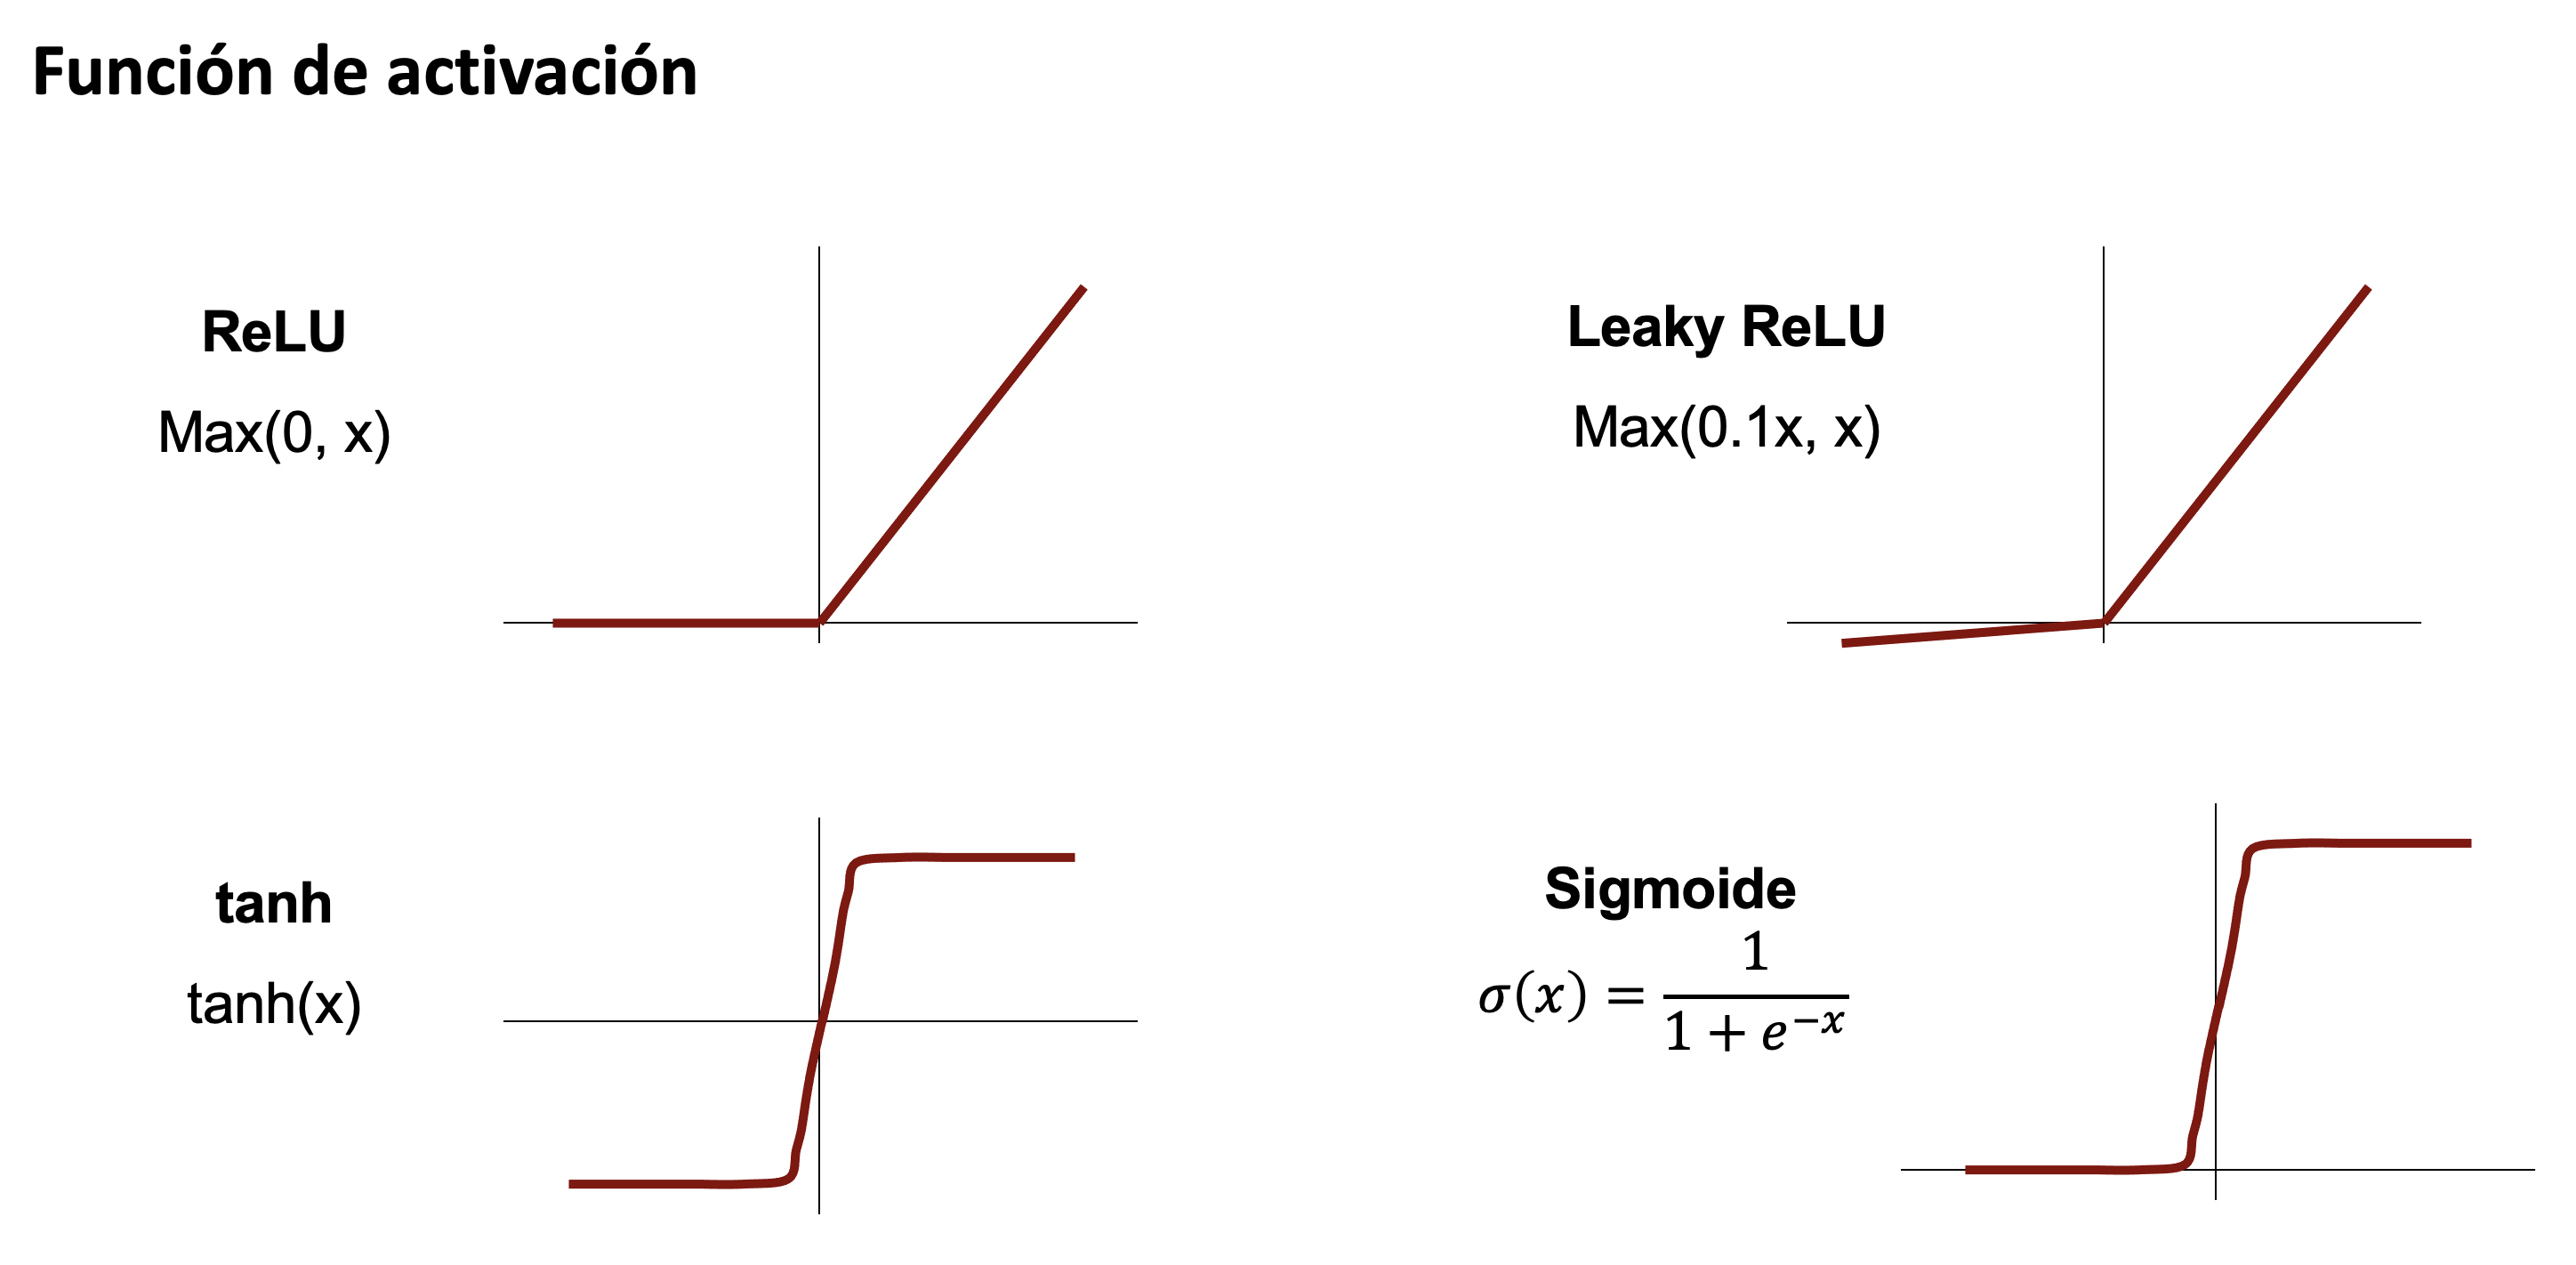

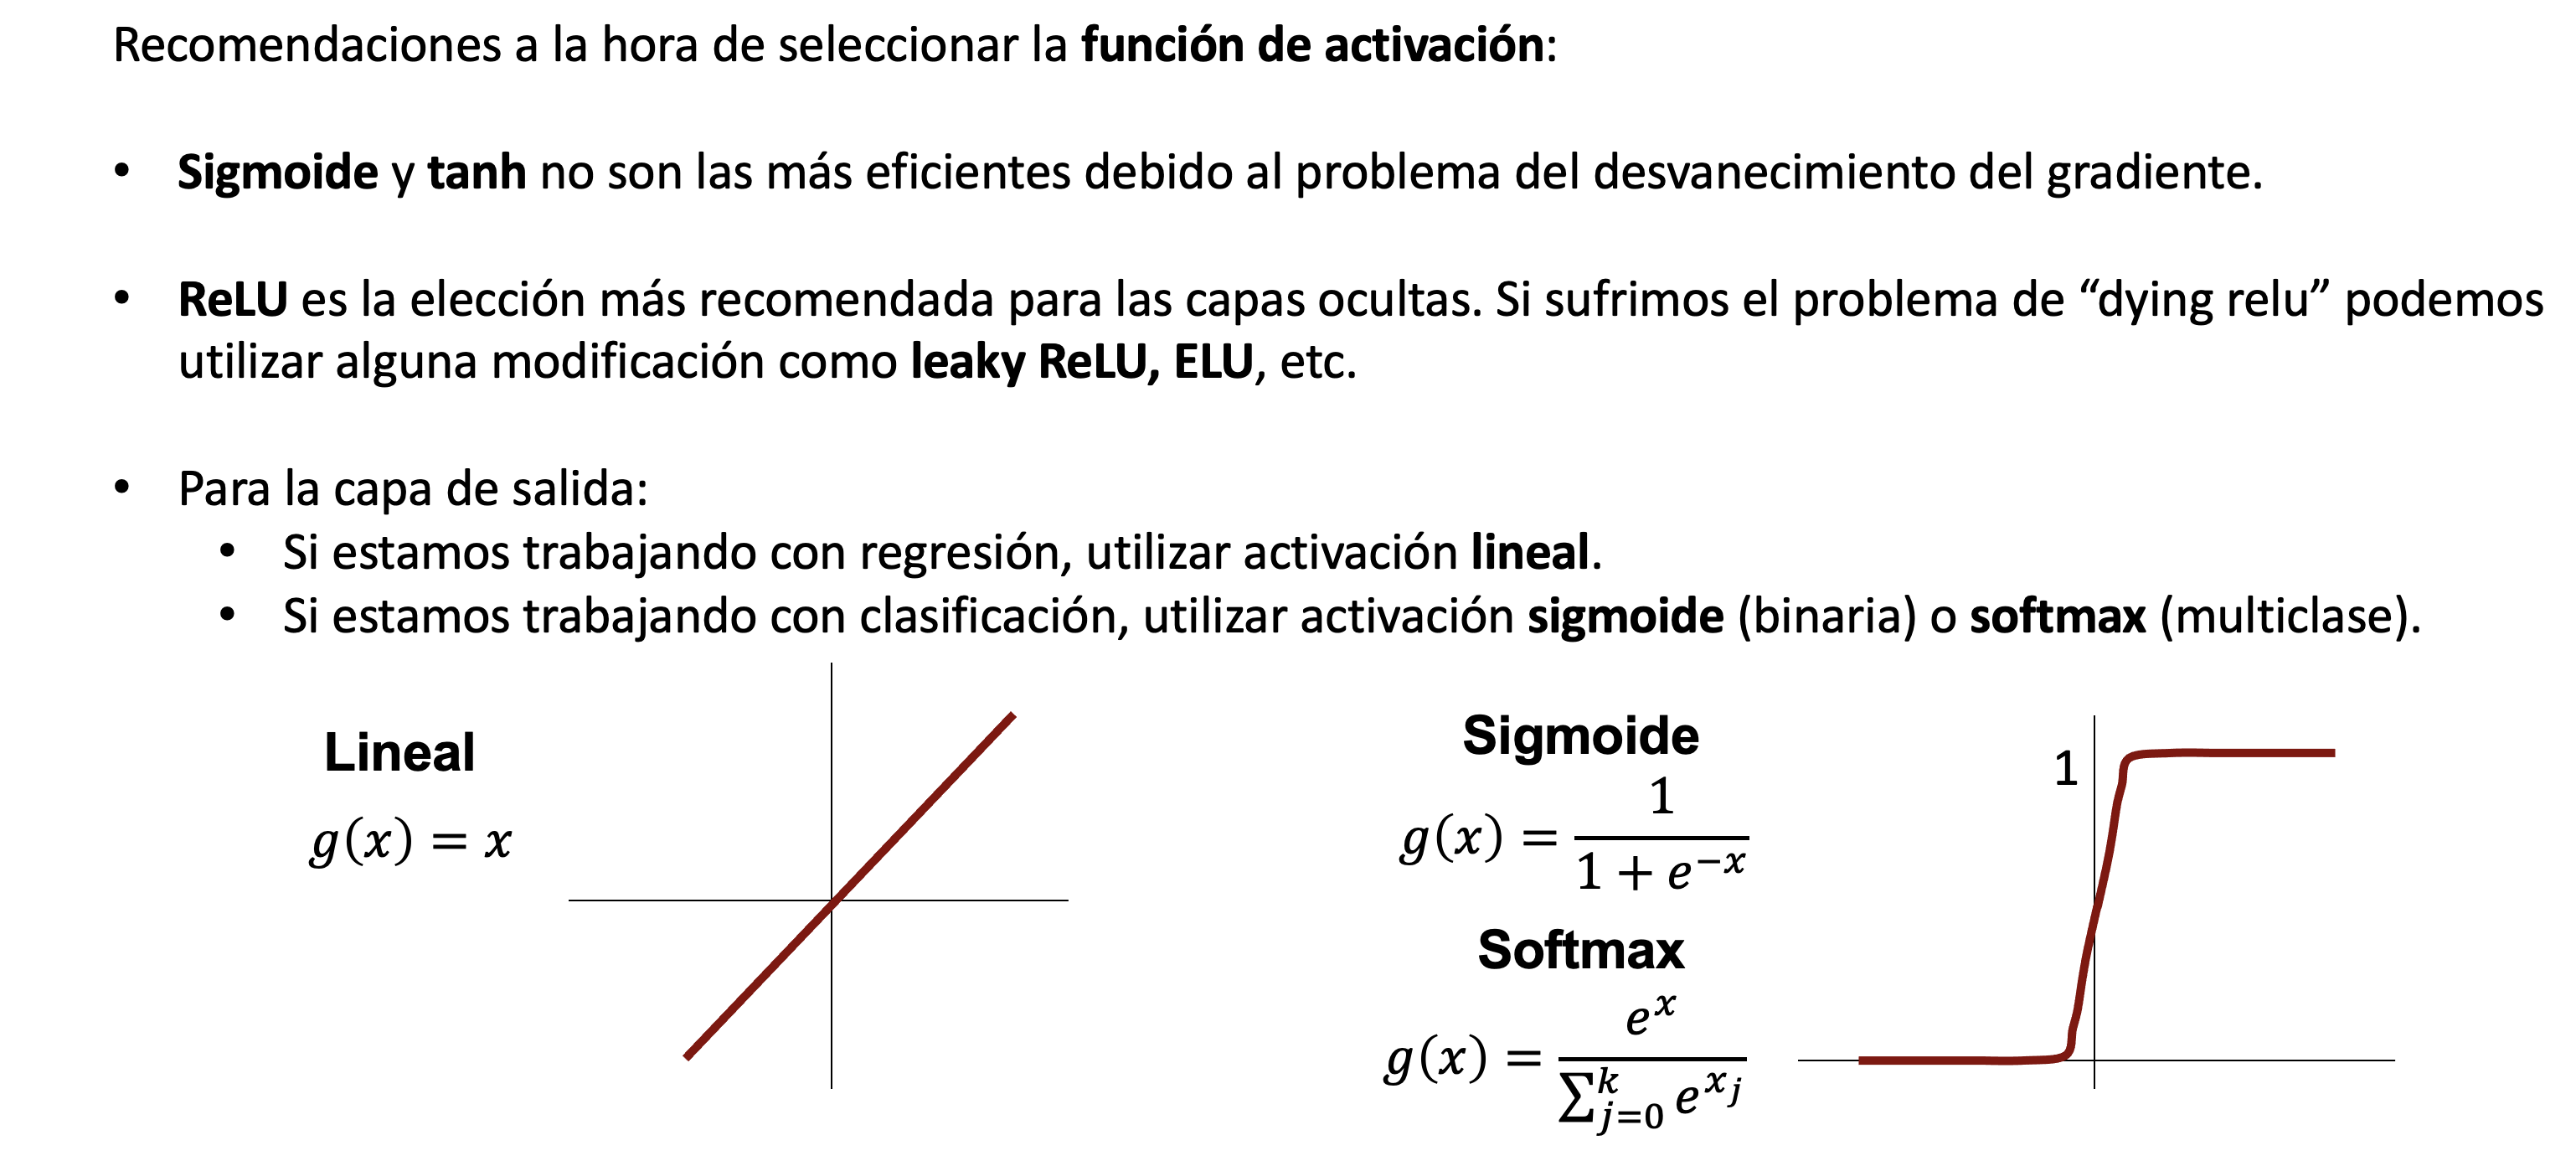

En esta sección vamos a comprobar el efecto de usar diferentes funciones de activiación en las capas ocultas. Vamos a probar:
- Lineal (None)
- Sigmoide (sigmoid)
- Tangente hiperbólicca (tanh)
- ReLU (relu)

In [ ]:
# Creamos método con la función de activación como parámetro de entrada
def create_model_activation(n_features, activation):
    model = keras.Sequential()
    model.add(Dense(20, activation=activation, input_shape=(n_features,)))
    model.add(Dense(50, activation=activation, input_shape=(n_features,)))
    model.add(Dense(3, activation='softmax'))
    return model

In [ ]:
# Definimos los modelos a probar

# Lineal (no aplicar función de activación)
model_lineal = create_model_activation(X_train.shape[1], None)
model_lineal.compile(optimizer='adam', loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Sigmoide
model_sigmoid = create_model_activation(X_train.shape[1], 'sigmoid')
model_sigmoid.compile(optimizer='adam', loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Tangente hiperbólica
model_tanh = create_model_activation(X_train.shape[1], 'tanh')
model_tanh.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])

# ReLU
model_relu = create_model_activation(X_train.shape[1], 'relu')
model_relu.compile(optimizer='adam', loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
# Entrenamos los modelos

history_lineal = model_lineal.fit(X_train_norm, y_train_onehot, 
                                  epochs=100, batch_size=64,
                                  validation_data=(X_val_norm, y_val_onehot),
                                  verbose=0)

history_sigmoid = model_sigmoid.fit(X_train_norm, y_train_onehot, 
                                    epochs=100, batch_size=64,
                                    validation_data=(X_val_norm, y_val_onehot),
                                    verbose=0)

history_tanh = model_tanh.fit(X_train_norm, y_train_onehot, 
                              epochs=100, batch_size=64,
                              validation_data=(X_val_norm, y_val_onehot),
                              verbose=0)

history_relu = model_relu.fit(X_train_norm, y_train_onehot, 
                              epochs=100, batch_size=64,
                              validation_data=(X_val_norm, y_val_onehot),
                              verbose=0)

(0.6, 0.9)

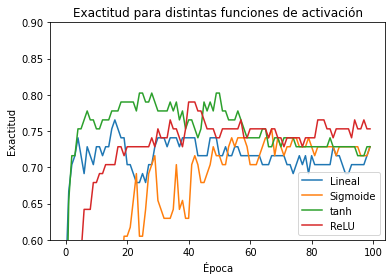

In [ ]:
plt.plot(history_lineal.history['val_accuracy'], label="Lineal")
plt.plot(history_sigmoid.history['val_accuracy'], label="Sigmoide")
plt.plot(history_tanh.history['val_accuracy'], label="tanh")
plt.plot(history_relu.history['val_accuracy'], label="ReLU")
plt.title('Exactitud para distintas funciones de activación')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.legend(loc='lower right')
plt.ylim([0.6, 0.9])

In [ ]:
_, acc_lineal = model_lineal.evaluate(X_test_norm, y_test_onehot, verbose=0)
_, acc_sigmoid = model_sigmoid.evaluate(X_test_norm, y_test_onehot, verbose=0)
_, acc_tanh = model_tanh.evaluate(X_test_norm, y_test_onehot, verbose=0)
_, acc_relu = model_relu.evaluate(X_test_norm, y_test_onehot, verbose=0)

print('Exactitud lineal: ', acc_lineal)
print('Exactitud sigmoide: ', acc_sigmoid)
print('Exactitud tanh: ', acc_tanh)
print('Exactitud relu: ', acc_relu)

Exactitud lineal:  0.7549019455909729
Exactitud sigmoide:  0.7450980544090271
Exactitud tanh:  0.7647058963775635
Exactitud relu:  0.7549019455909729


En este ejemplo sencillo no se ve tan clara la diferencia entre emplear una función de activación u otra. Vemos mismos resultados al emplear ReLU y tangente hiperbólica. Esto es porque aún no se ve afectado por el desvanecimiento de gradiente que ocurre en arquitecturas más profundas. Volveremos a ver este efecto de la función de activación cuando veamos arquitecturas más complejas.

# Tasa de aprendizaje

La tasa de aprendizaje es uno de los hiperparámetros más importantes a ajustar. Esta define la magnitud de cambio que se le aplican a los pesos de las conexiones entre las neuronas. Si esta es muy alta podemos llegar a un punto en el que el modelo entre en un mínimo local y no converja o incluso se desestabilice el entrenamiento, por contra, si es demasiado pequeña, el entrenamiento será demasiado lento.

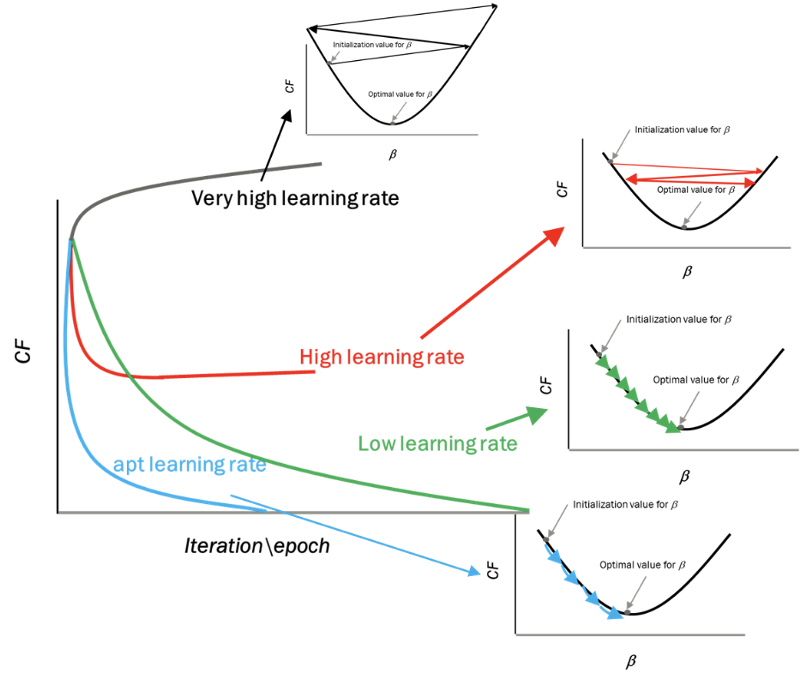

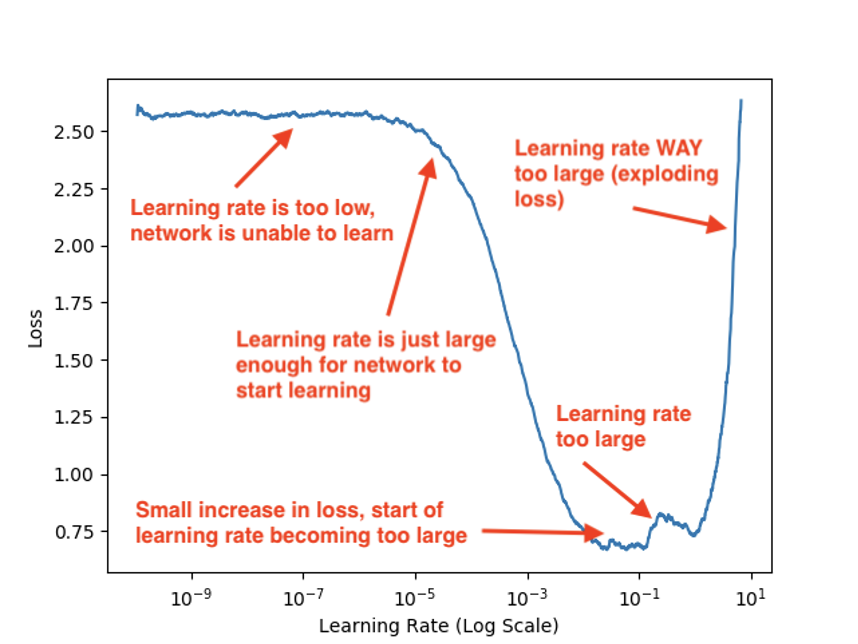

A la hora de elegir la tasa de aprendizaje tenemos diferentes opciones, entra las que encontramos:
- Tasa de aprendizaje **constante** durante todo el proceso de entrenamiento
- Tasa de aprendizaje **variable** durante el proceso de entrenamiento. Esta opción puede realizarse bien a través de **planificadores** que, a cada época, le asignan una tasa de aprendizaje concreta, o a través de **optimizadores**, como Adam, RMSProp, Adadelta, entre otros, que surgen de investigaciones de expertos en el campo que han desarrollado sus propios algoritmos de ajuste de la tasa de aprendizaje.

## Opción 1: Tasa de aprendizaje constante

En este caso, se define una tasa de aprendizaje al inicio del entrenamiento y se emplea la misma a lo largo de todo el proceso. Para ello se hace uso del optimizador basado en el descenso de gradiente estocástico.

Vamos a probar tasas de aprendizaje desde la 1 a 1e-6 en saltos de 0.1

**NOTA**: Dado que vamos a "jugar" con la tasa de aprendizaje, en lugar de emplear los parámetros por defecto que se emplean estableciendo el optimizador con valores clave ('adam', 'sgd', etc.), emplearemos los métodos que ofrece Keras

In [ ]:
# Método base para la creación del modelo de clasificación
def create_model_classification(n_features):
    model = keras.Sequential()
    model.add(Dense(20, activation='relu', input_shape=(n_features,)))
    model.add(Dense(3, activation='softmax'))
    return model

In [ ]:
learning_rates = [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

models = {}
histories = {}

for lr in learning_rates:

  print(f'Entrenando tasa de aprendizaje: {lr}')

  models['lr_'+str(lr)] = create_model_classification(X_train.shape[1])
  optimizer = SGD(learning_rate=lr)
  models['lr_'+str(lr)].compile(optimizer=optimizer, 
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])
  
  histories['lr_'+str(lr)] = models['lr_'+str(lr)].fit(X_train_norm, y_train_onehot, 
                                                       epochs=100, batch_size=64,
                                                       validation_data=(X_val_norm, y_val_onehot),
                                                       verbose=0)

Entrenando tasa de aprendizaje: 1
Entrenando tasa de aprendizaje: 0.1
Entrenando tasa de aprendizaje: 0.01
Entrenando tasa de aprendizaje: 0.001
Entrenando tasa de aprendizaje: 0.0001
Entrenando tasa de aprendizaje: 1e-05
Entrenando tasa de aprendizaje: 1e-06


In [ ]:
histories.keys()

dict_keys(['lr_1', 'lr_0.1', 'lr_0.01', 'lr_0.001', 'lr_0.0001', 'lr_1e-05', 'lr_1e-06'])

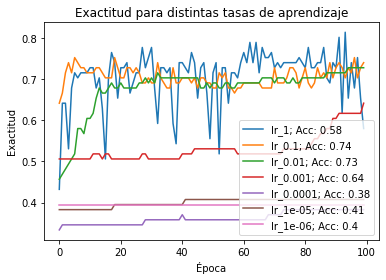

In [ ]:
# Mostramos exactitud en para cada TA con valor de última época en la leyenda
for key in histories.keys():

  last_acc = histories[key].history['val_accuracy'][-1]
  last_acc = np.round(last_acc, 2)
  plt.plot(histories[key].history['val_accuracy'], label=key + '; Acc: ' + str(last_acc))

plt.title('Exactitud para distintas tasas de aprendizaje')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.legend(loc='lower right')

Podemos ver como con una tasa de aprendizaje alta (1) experimentamos un entrenamiento muy inestable (cambios muy grandes en la exactitud entre una iteración y otra). Por otro lado, vemos que con tasas de aprendizaje muy bajas (<0.001) el entrenamiento es tan lento que el modelo no llega a converger.

In [ ]:
for key in models.keys():
  _, acc = models[key].evaluate(X_test_norm, y_test_onehot, verbose=0)
  print(f'Exactitud {key}: {acc}')

Exactitud lr_1: 0.5882353186607361
Exactitud lr_0.1: 0.7843137383460999
Exactitud lr_0.01: 0.6666666865348816
Exactitud lr_0.001: 0.5980392098426819
Exactitud lr_0.0001: 0.38235294818878174
Exactitud lr_1e-05: 0.4313725531101227
Exactitud lr_1e-06: 0.44117647409439087


##Opción 2: Tasa de aprendizaje variable: Planificadores
La tasa de aprendizaje que se emplea durante el proceso de entrenamiento puede variar a lo largo del mismo. Esto es de especial interés ya que nos interesaría poder emplear una tasa de aprendizaje elevada en las primeras iteraciones e ir disminuyéndola conforme avanza el entrenamiento para realizar un ajuste más fino de los pesos y poder salir, en su caso, de un mínimo local que hayamos encontrado.

Para implementar estos planificadores haremos uso del callback que ofrece Keras "[LearningRateScheduler](https://keras.io/api/callbacks/learning_rate_scheduler/)".

Vamos a ver como implementar un planificador basado en un cambio de la tasa de aprendizaje exponencial.

In [ ]:
# Definimos el método
def exponential_decay(epoch, lr):

  initLR = 0.1
  k = 0.01
  alpha = initLR * math.exp(-k*epoch)
  return float(alpha)

Text(0, 0.5, 'Tasa de aprendizaje')

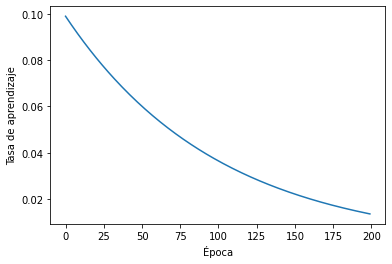

In [ ]:
# Visualizamos los valores que toma la TA durante el entrenamiento
alphas = []
for i in range(200):
  alphas.append(0.1 * math.exp(-0.01*(i+1)))

plt.plot(alphas)
plt.xlabel('Época')
plt.ylabel('Tasa de aprendizaje')

In [ ]:
# Inicializamos el planificador
schedule = LearningRateScheduler(exponential_decay, verbose=1)

model_sch_exp = create_model_classification(X_train.shape[1])
optimizer = SGD()
model_sch_exp.compile(optimizer=optimizer, 
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

history_sch_exp = model_sch_exp.fit(X_train_norm, y_train_onehot, 
                                    epochs=100, batch_size=64,
                                    validation_data=(X_val_norm, y_val_onehot),
                                    callbacks=[schedule],
                                    verbose=1)

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.1.
6/6 [==============================] - 0s 30ms/step - loss: 0.9071 - accuracy: 0.5666 - val_loss: 0.7943 - val_accuracy: 0.6173
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.09900498337491681.
6/6 [==============================] - 0s 5ms/step - loss: 0.7501 - accuracy: 0.6842 - val_loss: 0.7202 - val_accuracy: 0.6667
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.09801986733067553.
6/6 [==============================] - 0s 6ms/step - loss: 0.6569 - accuracy: 0.7492 - val_loss: 0.6813 - val_accuracy: 0.6914
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.09704455335485082.
6/6 [==============================] - 0s 7ms/step - loss: 0.6073 - accuracy: 0.7585 - val_loss: 0.6634 - val_accuracy: 0.7037
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.09607894391523232.
6/6 [==============================] 

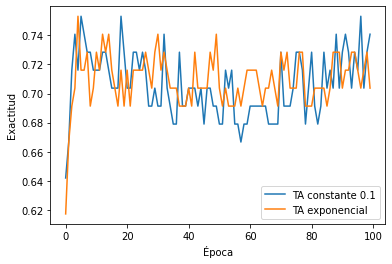

In [ ]:
# Comparamos exactitud en validación tasa de aprendizaje constante con TA=1 y TA=0.1 frente a planificador exponencial con TA inicial de 1
#plt.plot(histories['lr_1'].history['val_accuracy'], label='TA constante 1')
plt.plot(histories['lr_0.1'].history['val_accuracy'], label='TA constante 0.1')
plt.plot(history_sch_exp.history['val_accuracy'], label='TA exponencial')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.legend()

In [ ]:
_, acc_lr1 = models['lr_1'].evaluate(X_test_norm, y_test_onehot, verbose=0)
_, acc_lr01 = models['lr_0.1'].evaluate(X_test_norm, y_test_onehot, verbose=0)
_, acc_lrexp = model_sch_exp.evaluate(X_test_norm, y_test_onehot, verbose=0)
print(f'Exactitud TA 1: {acc_lr1}')
print(f'Exactitud TA 0.1: {acc_lr01}')
print(f'Exactitud TA exponencial: {acc_lrexp}')

Exactitud TA 1: 0.5882353186607361
Exactitud TA 0.1: 0.7843137383460999
Exactitud TA exponencial: 0.7843137383460999


Del mismo modo que hemos implementado la tasa de aprendizaje exponencial, podemos implementar todas als funciones que se nos ocurran.

Algunos ejemplos:

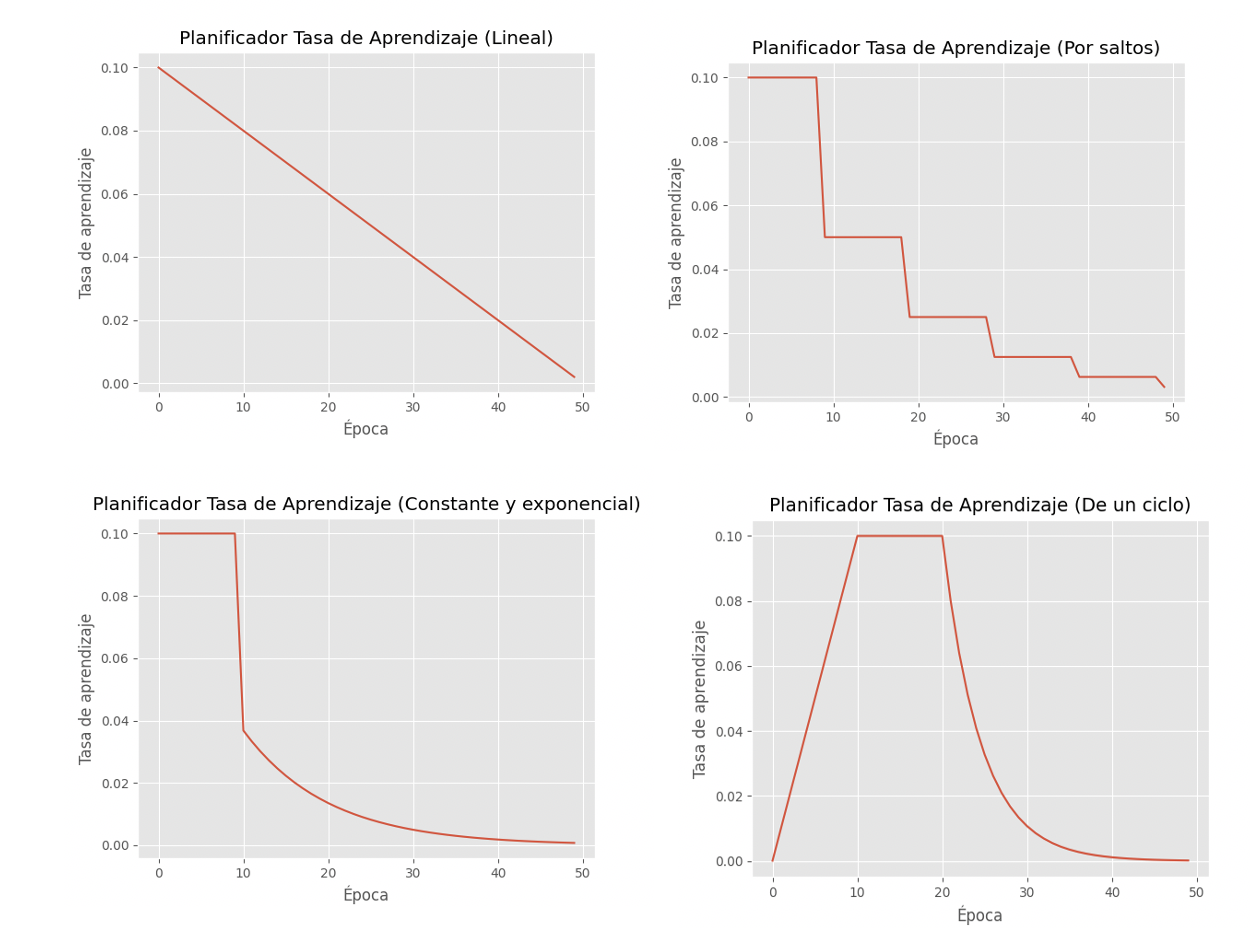

Otro tipo de variación de la tasa de aprendizaje sería realizar esta reducción de manera dinámica. Por ejemplo, con el *callback* de Keras "[ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/)" podemos especificar que, cuando las métricas se mantengan constante un número dado de épocas, se reduzca la tasa de aprendizaje un factor determinado.

Vamos a ver como implementar este *callback*.

In [ ]:
model_lr_plateau = create_model_classification(X_train.shape[1])
optimizer = SGD(learning_rate=0.1)
model_lr_plateau.compile(optimizer=optimizer, 
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                         patience=20, min_lr=1e-9, verbose=1)

history_lr_plateau = model_lr_plateau.fit(X_train_norm, y_train_onehot, 
                                          epochs=100, batch_size=64,
                                          validation_data=(X_val_norm, y_val_onehot),
                                          callbacks=[rlrp],
                                          verbose=0)


Epoch 00060: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.

Epoch 00080: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.

Epoch 00100: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.


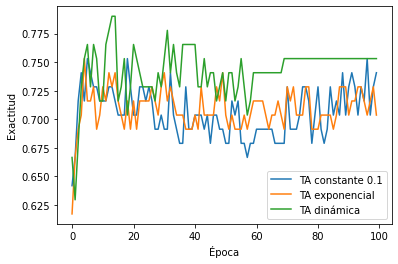

In [ ]:
plt.plot(histories['lr_0.1'].history['val_accuracy'], label='TA constante 0.1')
plt.plot(history_sch_exp.history['val_accuracy'], label='TA exponencial')
plt.plot(history_lr_plateau.history['val_accuracy'], label='TA dinámica')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.legend()

In [ ]:
_, acc_lrdyn = model_lr_plateau.evaluate(X_test_norm, y_test_onehot, verbose=0)
print(f'Exactitud TA 0.1: {acc_lr01}')
print(f'Exactitud TA exponencial: {acc_lrexp}')
print(f'Exactitud TA dinámica: {acc_lrdyn}')

Exactitud TA 0.1: 0.7843137383460999
Exactitud TA exponencial: 0.7843137383460999
Exactitud TA dinámica: 0.7745097875595093


## Opción 3: Tasa de aprendizaje variable: Optimizadores

Todo lo visto hasta ahora emplea el algoritmo dde descenso de gradiente estocástico (SGD) para la actualización de los pesos durante el entrenamiento. Sin embargo, existen una serie de retos:
 
 - La selección de la tasa de aprendizaje adecuada puede ser complicada y requiere de experimentación.

 - Seleccionar el planificador adecuado para cada problema puede resultar tedioso. Además, se añaden nuevos hiperparámetros a optimizar (e.g. facto de la caída exponencial).

 - Debemos evitar quedarnos "atrapados" en un mínimo local.

 - En SGD se aplica la misma tasa de aprendizaje a todos los pesos. Si nuestros datos son dispersos y nuestras características tienen diferentes frecuencias, puede que no deseemos actualizar todos los pesos de la misma forma.

 Para hacer frente a esto surgen diferentes optimizadores entre los que encontramos:

 - **Adagrad**: aplica TA menores a características que ocurren con mayor frecuencia y TA mayores a aquellas características poco frecuentes. Inconveniente: la TA cae a valores muy pequeños rápidamente, en cuyo momento la red no es capaz de seguir aprendiendo.
 - **Adadelta**: busca eliminar el problema de Adagrad.
 - **RMSprop**: igual que Adadelta, busca eliminar el problema de Adagrad (Adadelta y RMSporp aparecen en fechas similares).
 - **Adam**: se presenta como actualización dde Adadelta y RMSprop.


 Estos optimizadores están incluídos dentro de la [API de Keras](https://keras.io/api/optimizers/) y podemos emplearlos en nuestros modelos.


In [ ]:
model_adagrad = create_model_classification(X_train.shape[1])
model_adadelta = create_model_classification(X_train.shape[1])
model_rmsprop = create_model_classification(X_train.shape[1])
model_adam = create_model_classification(X_train.shape[1])

opt_adagrad = Adagrad(learning_rate=0.01, epsilon=1e-08, decay=0.0)
opt_adadelta = Adadelta(learning_rate=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
opt_rmsprop = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
opt_adam = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model_adagrad.compile(optimizer=opt_adagrad, 
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model_adadelta.compile(optimizer=opt_adadelta, 
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model_rmsprop.compile(optimizer=opt_rmsprop, 
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model_adam.compile(optimizer=opt_adam, 
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

history_adagrad = model_adagrad.fit(X_train_norm, y_train_onehot,
                                    epochs=100, batch_size=64,
                                    validation_data=(X_val_norm, y_val_onehot),
                                    verbose=0)

history_adadelta = model_adadelta.fit(X_train_norm, y_train_onehot,
                                      epochs=100, batch_size=64,
                                      validation_data=(X_val_norm, y_val_onehot),
                                      verbose=0)

history_rmsprop = model_rmsprop.fit(X_train_norm, y_train_onehot,
                                    epochs=100, batch_size=64,
                                    validation_data=(X_val_norm, y_val_onehot),
                                    verbose=0)

history_adam = model_adam.fit(X_train_norm, y_train_onehot,
                              epochs=100, batch_size=64,
                              validation_data=(X_val_norm, y_val_onehot),
                              verbose=0)

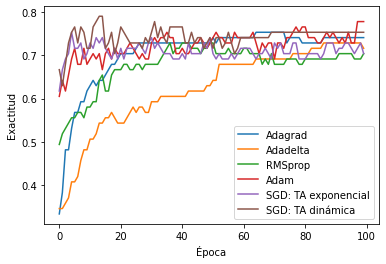

In [ ]:
plt.plot(history_adagrad.history['val_accuracy'], label='Adagrad')
plt.plot(history_adadelta.history['val_accuracy'], label='Adadelta')
plt.plot(history_rmsprop.history['val_accuracy'], label='RMSprop')
plt.plot(history_adam.history['val_accuracy'], label='Adam')
plt.plot(history_sch_exp.history['val_accuracy'], label='SGD: TA exponencial')
plt.plot(history_lr_plateau.history['val_accuracy'], label='SGD: TA dinámica')

plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.legend()

In [ ]:
_, acc_adam = model_adam.evaluate(X_test_norm, y_test_onehot, verbose=0)
_, acc_rmsprop = model_rmsprop.evaluate(X_test_norm, y_test_onehot, verbose=0)
_, acc_adadelta = model_adadelta.evaluate(X_test_norm, y_test_onehot, verbose=0)
_, acc_adagrad = model_adagrad.evaluate(X_test_norm, y_test_onehot, verbose=0)

print(f'Exactitud SGD TA exponencial: {acc_lrexp}')
print(f'Exactitud SGD TA dinámica: {acc_lrdyn}')
print(f'Exactitud Adam: {acc_adam}')
print(f'Exactitud RMSprop: {acc_rmsprop}')
print(f'Exactitud Adadelta: {acc_adadelta}')
print(f'Exactitud Adagrad: {acc_adagrad}')

Exactitud SGD TA exponencial: 0.7843137383460999
Exactitud SGD TA dinámica: 0.7745097875595093
Exactitud Adam: 0.7941176295280457
Exactitud RMSprop: 0.7843137383460999
Exactitud Adadelta: 0.5686274766921997
Exactitud Adagrad: 0.6666666865348816


# Tamaño de lote o batch

Para el cálculo de los pesos se emplea el algoritmo de descenso de gradiente (opción 1), sin embargo, emplear todo el conjunto de datos puede ser muy costoso computacionalmente, por ello, se divide el cconjunto de datos de entrenamiento en lotes y se ajustan los pesos de manera iterativa con cada lote, debido a que la selección de estos lotes es aleatoria, el algoritmo pasa a llamarsa descenso de gradiente estocástico.

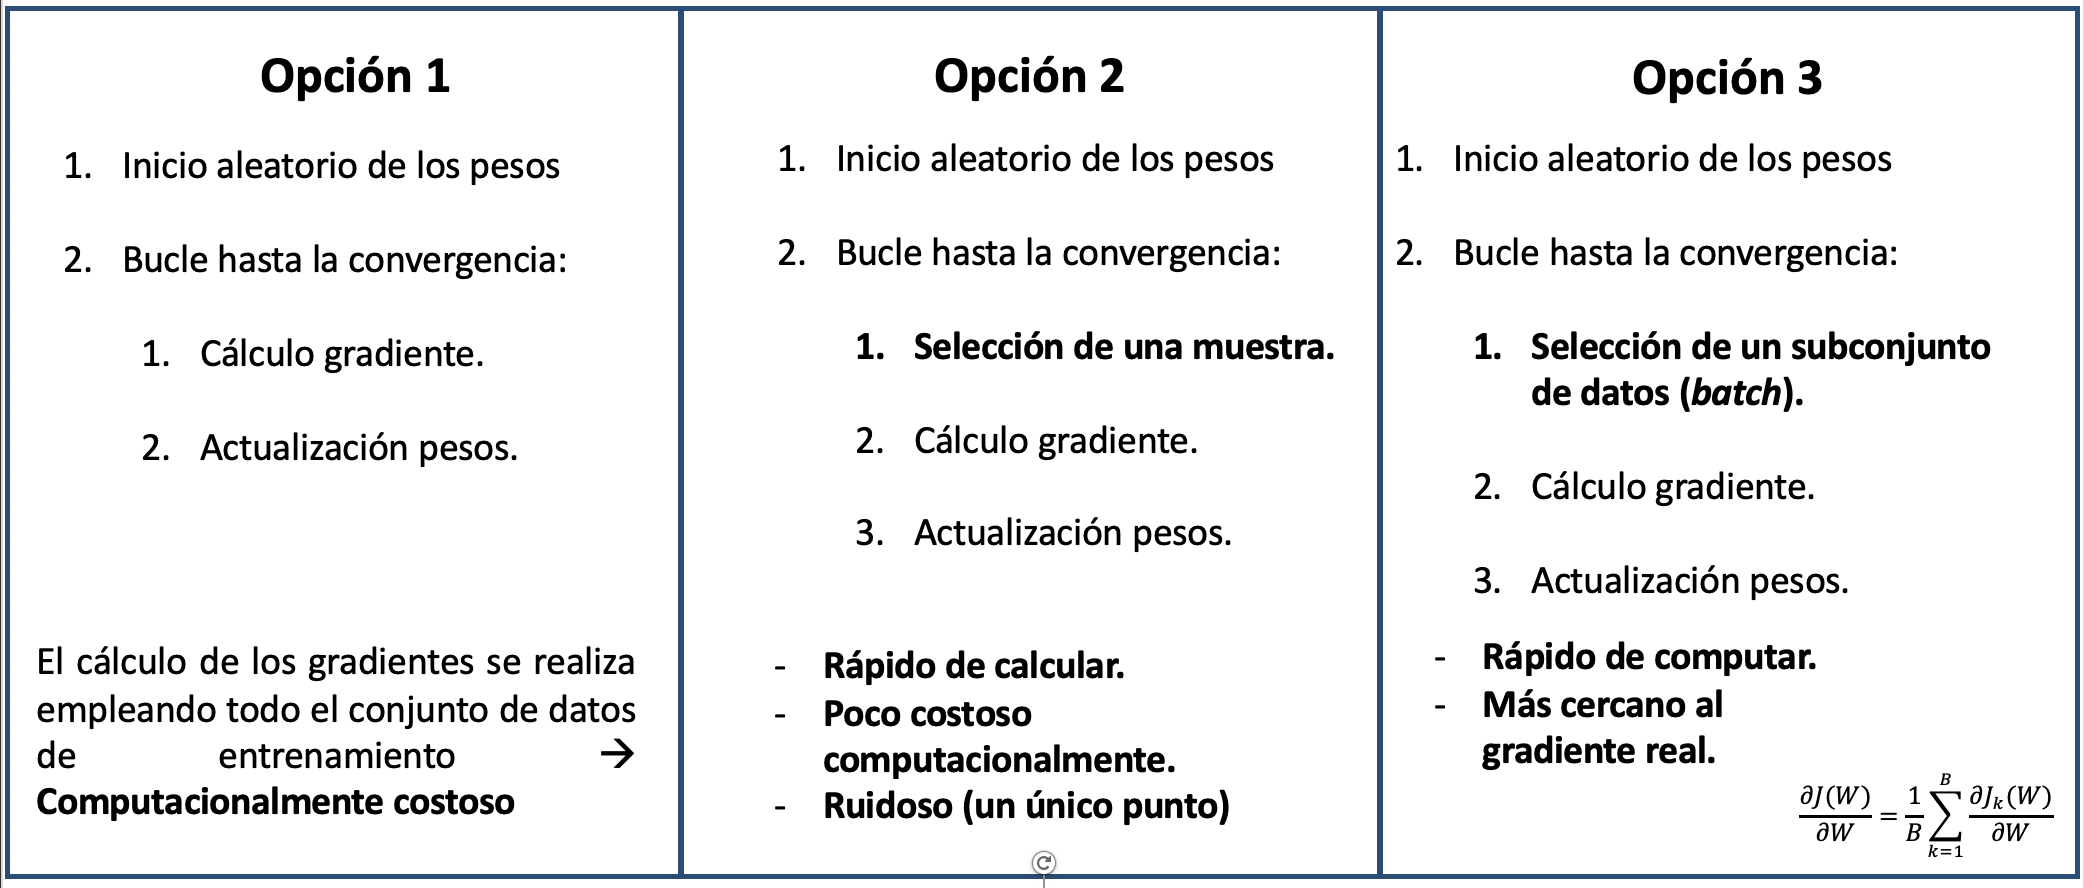

Cuando diseñamos una arquitectura, uno de los hiperparámetros a definir es el tamaño de lote (batch_size). Vamos a ver el efecto de este parámetro.

In [ ]:
batch_sizes = [5, 10, 20, 40, 80, 100, 200]

models_bs = {}
histories_bs = {}

for bs in batch_sizes:

  print(f'Entrenando tamaño lote: {bs}')

  models_bs['bs_'+str(bs)] = create_model_classification(X_train.shape[1])
  optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  models_bs['bs_'+str(bs)].compile(optimizer=optimizer, 
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])
  
  histories_bs['bs_'+str(bs)] = models_bs['bs_'+str(bs)].fit(X_train_norm, y_train_onehot, 
                                                            epochs=100, batch_size=bs,
                                                            validation_data=(X_val_norm, y_val_onehot),
                                                            verbose=0)

Entrenando tamaño lote: 5
Entrenando tamaño lote: 10
Entrenando tamaño lote: 20
Entrenando tamaño lote: 40
Entrenando tamaño lote: 80
Entrenando tamaño lote: 100
Entrenando tamaño lote: 200


(0.4, 0.9)

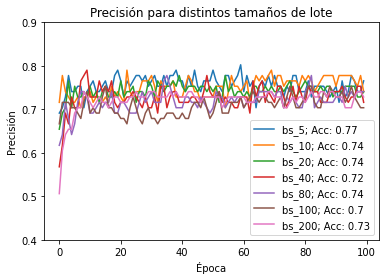

In [ ]:
for key in histories_bs.keys():

  last_acc = histories_bs[key].history['val_accuracy'][-1]
  last_acc = np.round(last_acc, 2)
  plt.plot(histories_bs[key].history['val_accuracy'], label=key + '; Acc: ' + str(last_acc))

plt.title('Precisión para distintos tamaños de lote')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(loc='lower right')
plt.ylim([0.4, 0.9])

In [ ]:
for key in models_bs.keys():
  _, acc = models_bs[key].evaluate(X_test_norm, y_test_onehot, verbose=0)
  print(f'Exactitud {key}: {acc}')

Exactitud bs_5: 0.7549019455909729
Exactitud bs_10: 0.7745097875595093
Exactitud bs_20: 0.7549019455909729
Exactitud bs_40: 0.7745097875595093
Exactitud bs_80: 0.8039215803146362
Exactitud bs_100: 0.7745097875595093
Exactitud bs_200: 0.7647058963775635


# Número de épocas

El número de épocas es un parámetro importante de establecer para evitar el sobreajuste o el subajuste.

- Si no entrenamos el modelo el número de épocas suficientes, el modelo quedará subajustado, no llegará a optimizarse todo lo posible.

- Si entrenamos el modelo durante un número de épocas muy largo, el modelo empezará a sobreajustarse, adeptándose demasiado al conjunto de datos de entrenamiento y no siendo capaz de generalizar a nuevos datos.

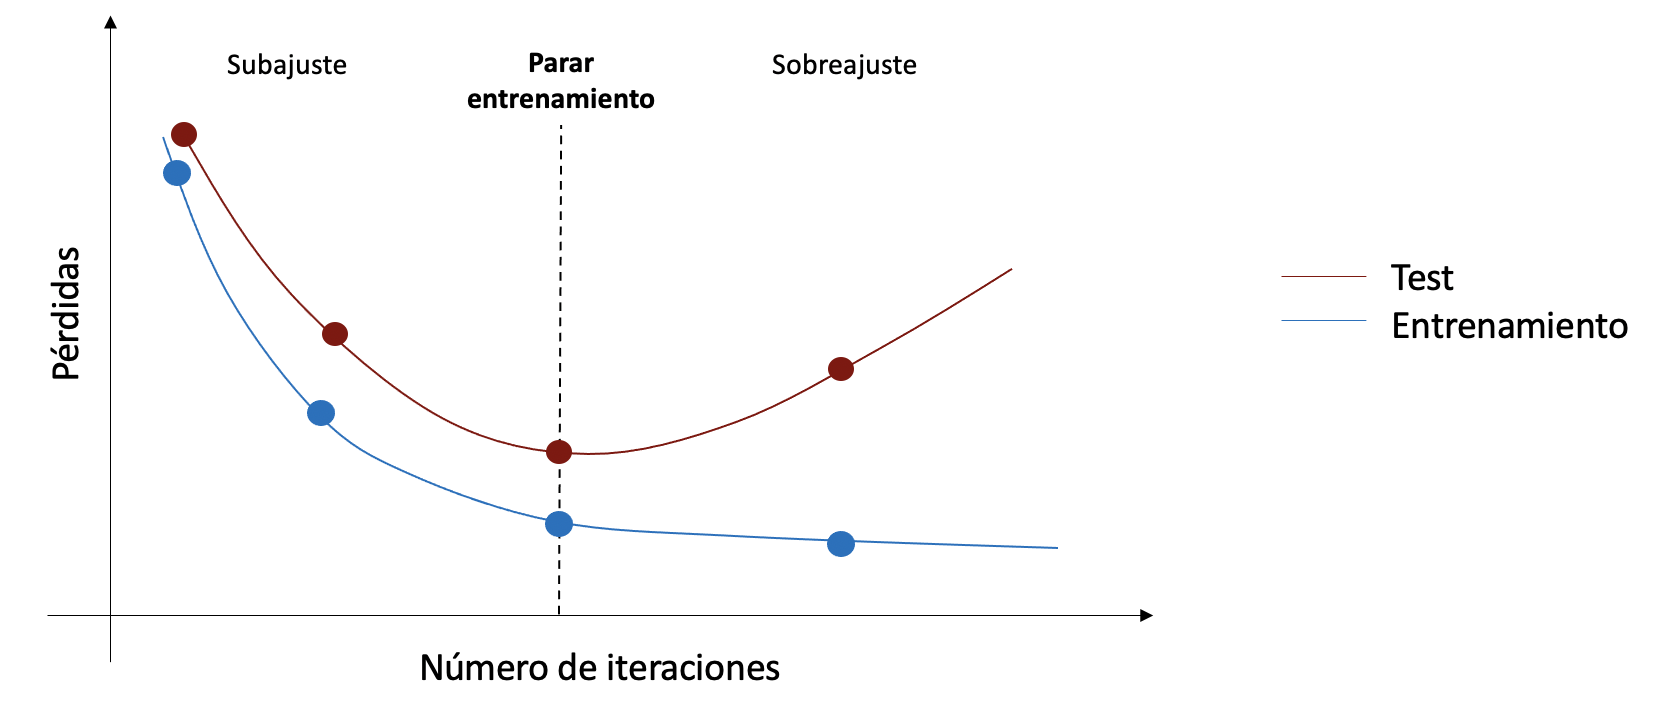

In [ ]:
epochs = [10, 20, 100, 200, 500, 1000]

models_ep = {}
histories_ep = {}

for epoch in epochs:

  print(f'Entrenando número épocas: {epoch}')

  models_ep['ep_'+str(epoch)] = create_model_classification(X_train.shape[1])
  optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  models_ep['ep_'+str(epoch)].compile(optimizer=optimizer, 
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])
  
  histories_ep['ep_'+str(epoch)] = models_ep['ep_'+str(epoch)].fit(X_train_norm, y_train_onehot, 
                                                            epochs=epoch, batch_size=40,
                                                            validation_data=(X_val_norm, y_val_onehot),
                                                            verbose=0)

Entrenando número épocas: 10
Entrenando número épocas: 20
Entrenando número épocas: 100
Entrenando número épocas: 200
Entrenando número épocas: 500
Entrenando número épocas: 1000


(0.0, 1.0)

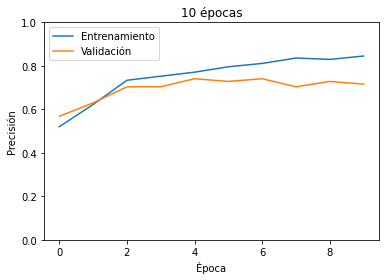

In [ ]:
plt.plot(histories_ep['ep_10'].history['accuracy'], label='Entrenamiento')
plt.plot(histories_ep['ep_10'].history['val_accuracy'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('10 épocas')
plt.legend()
plt.ylim([0,1])

(0.0, 1.0)

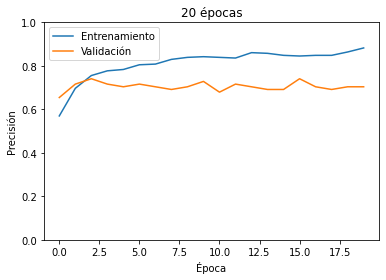

In [ ]:
plt.plot(histories_ep['ep_20'].history['accuracy'], label='Entrenamiento')
plt.plot(histories_ep['ep_20'].history['val_accuracy'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('20 épocas')
plt.legend()
plt.ylim([0,1])

(0.0, 1.0)

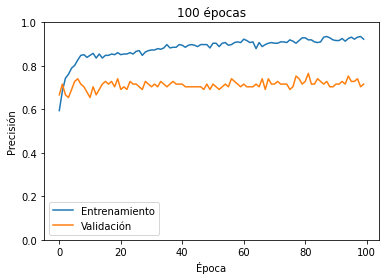

In [ ]:
plt.plot(histories_ep['ep_100'].history['accuracy'], label='Entrenamiento')
plt.plot(histories_ep['ep_100'].history['val_accuracy'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('100 épocas')
plt.legend()
plt.ylim([0,1])

(0.0, 1.0)

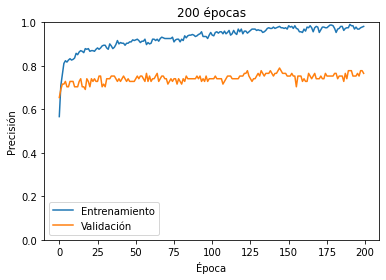

In [ ]:
plt.plot(histories_ep['ep_200'].history['accuracy'], label='Entrenamiento')
plt.plot(histories_ep['ep_200'].history['val_accuracy'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('200 épocas')
plt.legend()
plt.ylim([0,1])

(0.0, 1.0)

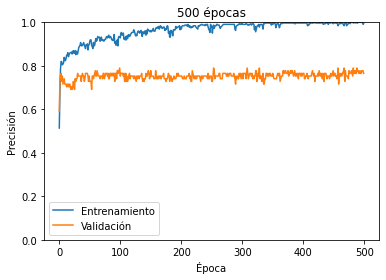

In [ ]:
plt.plot(histories_ep['ep_500'].history['accuracy'], label='Entrenamiento')
plt.plot(histories_ep['ep_500'].history['val_accuracy'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('500 épocas')
plt.legend()
plt.ylim([0,1])

(0.0, 1.0)

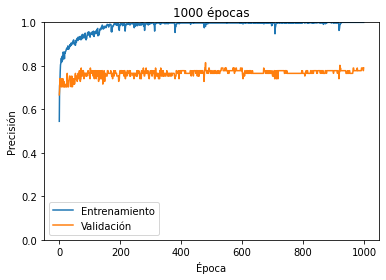

In [ ]:
plt.plot(histories_ep['ep_1000'].history['accuracy'], label='Entrenamiento')
plt.plot(histories_ep['ep_1000'].history['val_accuracy'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('1000 épocas')
plt.legend()
plt.ylim([0,1])

Podemos observar como con número de épocas bajo (10-20), cuando finaliza el entrenamiento parece que la curva de la exactitud no ha terminado de aumentar, es decir, hemos parado el entrenamiento antes de que el modelo se ajuste del todo.

Por contra, con número de épocas alto (a partir de 200) vemos como el modelo empieza a sobreajustar. Llegamos a obtener una exactitud del 100% en entrenamiento mientras que en validacción ya ha saturado, hay una gran diferencia entre estos valores.

Para ajustar este hiperparámetro, en la API de Keras se incluye un callback ([EarlyStopping](https://keras.io/api/callbacks/early_stopping/)) que permite detener el entrenamiento cuuando las métricas en validación no sufren una mejora un número determinado de épocas.

In [ ]:
earlystopping = EarlyStopping(monitor="val_loss",
                              mode="min", patience=10,
                              restore_best_weights=True,
                              verbose=1)

model_stop = create_model_classification(X_train.shape[1])
optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_stop.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history_stop = model_stop.fit(X_train_norm, y_train_onehot, 
                              epochs=200, batch_size=64,
                              validation_data=(X_val_norm, y_val_onehot),
                              callbacks=[earlystopping],
                              verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping


(0.0, 1.0)

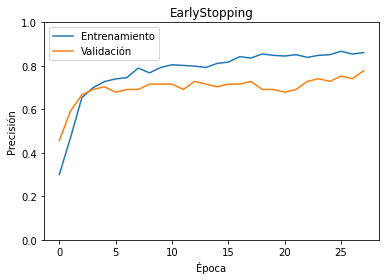

In [ ]:
plt.plot(history_stop.history['accuracy'], label='Entrenamiento')
plt.plot(history_stop.history['val_accuracy'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('EarlyStopping')
plt.legend()
plt.ylim([0,1])

# Regularización

Dentro de la regularización entran todas aquellas técnicas que se puedan aplicar para reducir el sobreajuste.

Previamente hemos visto una técnica de regularización, como es la selección del número adecuado de épocas. Sin embargo, aquí también se incluyen aquellas que ayudan a reducir la complejidad del propio modelo.

## Opción 1: Dropout

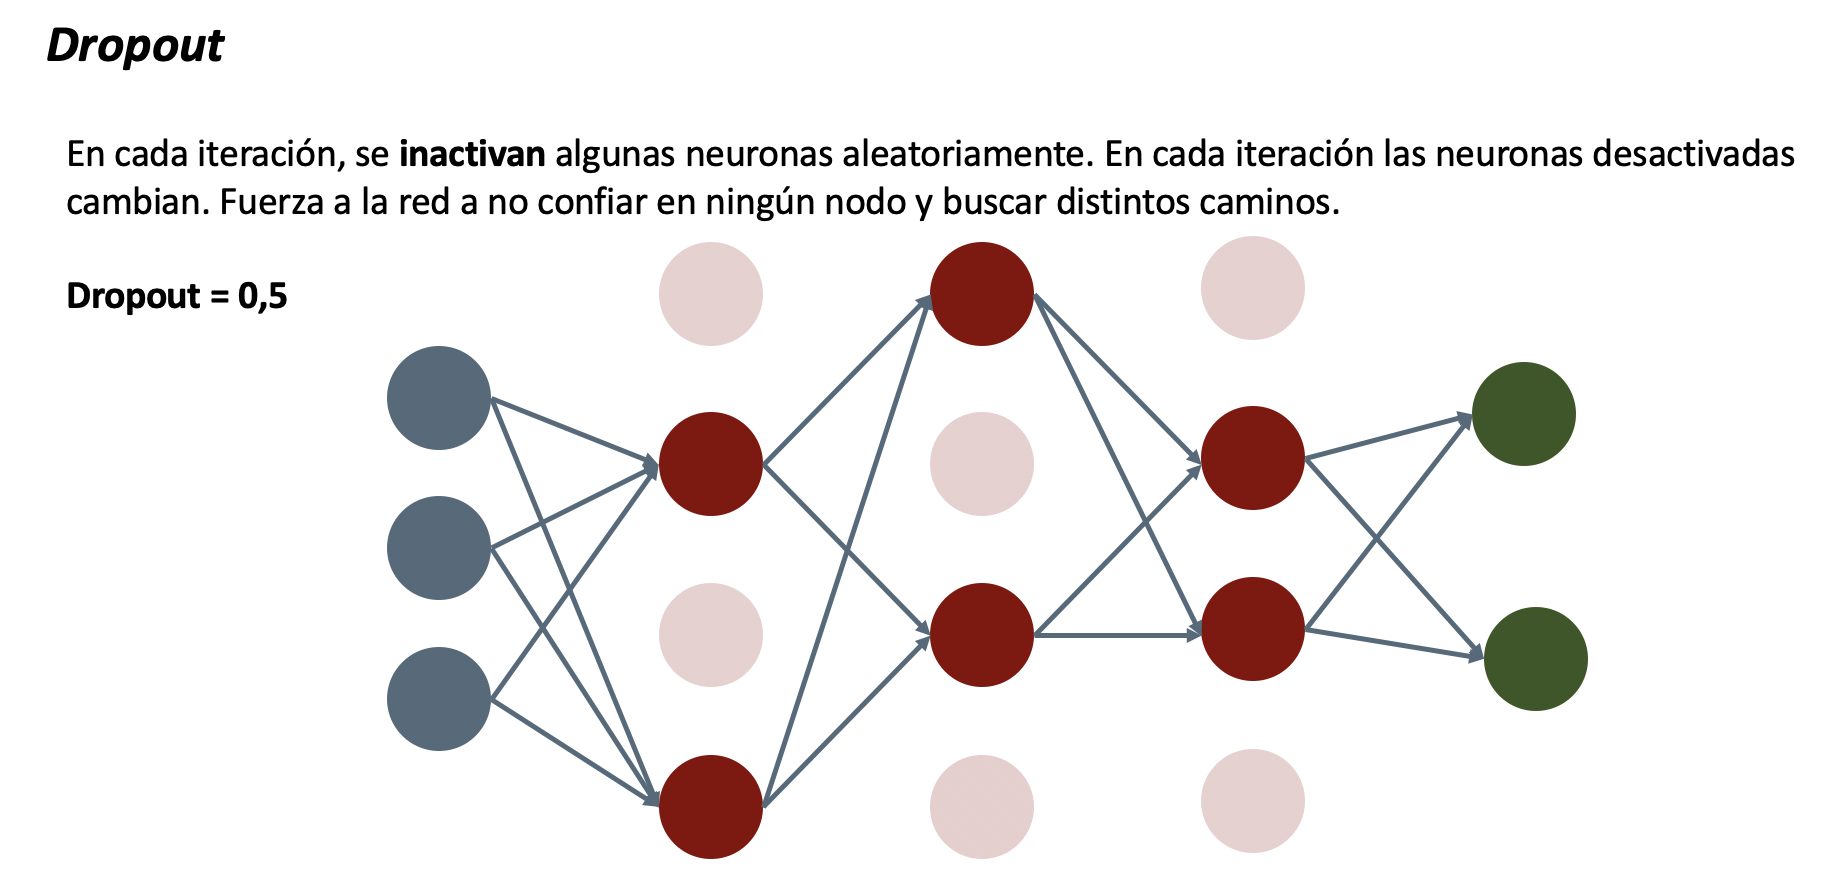

In [ ]:
# Método base para la creación del modelo de clasificación
def create_model_dropout(n_features):
    model = keras.Sequential()
    model.add(Dense(20, activation='relu', input_shape=(n_features,)))
    model.add(Dropout(0.25))
    model.add(Dense(3, activation='softmax'))
    return model

In [ ]:
model_drop = create_model_dropout(X_train.shape[1])
optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model_drop.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history_drop = model_drop.fit(X_train_norm, y_train_onehot, 
                              epochs=200, batch_size=64,
                              validation_data=(X_val_norm, y_val_onehot),
                              callbacks=[earlystopping],
                              verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping


(0.0, 1.0)

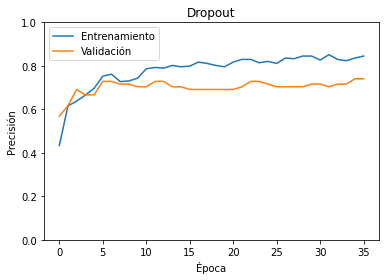

In [ ]:
plt.plot(history_drop.history['accuracy'], label='Entrenamiento')
plt.plot(history_drop.history['val_accuracy'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Dropout')
plt.legend()
plt.ylim([0,1])

Con respecto a la gráfica anterior podemos ver que el sobreajuste (diferencia entre la precisiíon en entrenamiento y validación) se ha reducido.

In [ ]:
print('Precisión validación sin dropout: ', history_stop.history['val_accuracy'][-1])
print('Precisión validación con dropout: ', history_drop.history['val_accuracy'][-1])

Precisión validación sin dropout:  0.7777777910232544
Precisión validación con dropout:  0.7407407164573669


In [ ]:
_, acc = model_stop.evaluate(X_test_norm, y_test_onehot, verbose=0)
_, acc_dropout = model_drop.evaluate(X_test_norm, y_test_onehot, verbose=0)

print('Precisión test sin dropout: ', acc)
print('Precisión test con dropout: ', acc_dropout)

Precisión test sin dropout:  0.7745097875595093
Precisión test con dropout:  0.7745097875595093


## Opción 2: Regularización L1, L2, L1-L2

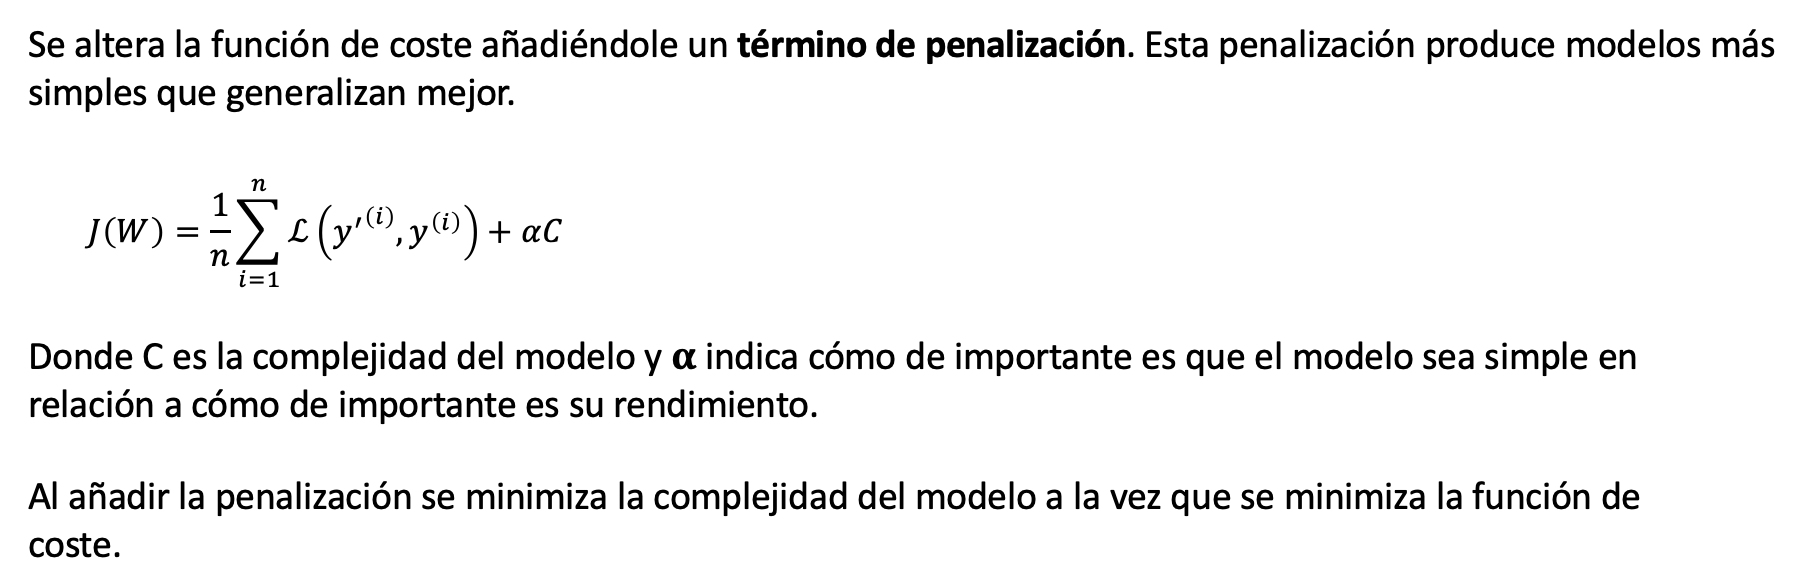

Dentro de la API de Keras tenemos la posibilidad de implementar [regularizadores](https://keras.io/api/layers/regularizers/) L1, L2 y L1-L2 de manera sencilla.

In [ ]:
# Método base para la creación del modelo de clasificación con regularización
def create_model_regularizers(n_features, regularizer):
    model = keras.Sequential()
    model.add(Dense(20, activation='relu', input_shape=(n_features,),
                    kernel_regularizer=regularizer))
    model.add(Dense(3, activation='softmax'))
    return model

In [ ]:
regs = [regularizers.l1(0.01), regularizers.l2(0.01), regularizers.l1_l2(0.01)]
reg_names = ['L1', 'L2', 'L1-L2']

models_reg = {}
histories_reg = {}

for r, reg in enumerate(regs):

  print(f'Entrenamiento modelo con regularizacion: {reg_names[r]}')

  models_reg[reg_names[r]] = create_model_regularizers(X_train.shape[1], reg)
  optimizer = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
  models_reg[reg_names[r]].compile(optimizer=optimizer, 
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])
  
  histories_reg[reg_names[r]] = models_reg[reg_names[r]].fit(X_train_norm, y_train_onehot, 
                                                             epochs=epoch, batch_size=40,
                                                             validation_data=(X_val_norm, y_val_onehot),
                                                             callbacks=[earlystopping],
                                                             verbose=0)

Entrenamiento modelo con regularizacion: L1
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Entrenamiento modelo con regularizacion: L2
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Entrenamiento modelo con regularizacion: L1-L2
Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping


(0.0, 1.0)

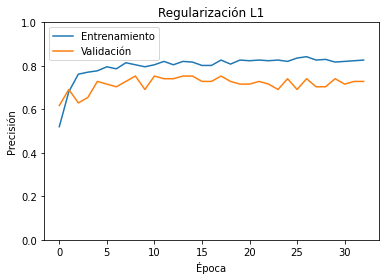

In [ ]:
plt.plot(histories_reg['L1'].history['accuracy'], label='Entrenamiento')
plt.plot(histories_reg['L1'].history['val_accuracy'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Regularización L1')
plt.legend()
plt.ylim([0,1])

(0.0, 1.0)

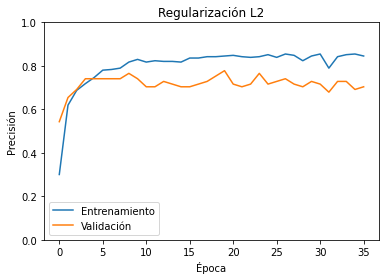

In [ ]:
plt.plot(histories_reg['L2'].history['accuracy'], label='Entrenamiento')
plt.plot(histories_reg['L2'].history['val_accuracy'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Regularización L2')
plt.legend()
plt.ylim([0,1])

(0.0, 1.0)

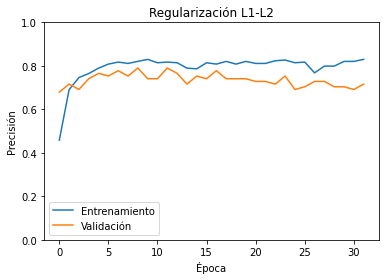

In [ ]:
plt.plot(histories_reg['L1-L2'].history['accuracy'], label='Entrenamiento')
plt.plot(histories_reg['L1-L2'].history['val_accuracy'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Regularización L1-L2')
plt.legend()
plt.ylim([0,1])

In [ ]:
print('Precisión validación sin regularización: ', history_stop.history['val_accuracy'][-1])
print('Precisión validación con dropout: ', history_drop.history['val_accuracy'][-1])
print('Precisión validación con reg. L1: ', histories_reg['L1'].history['val_accuracy'][-1])
print('Precisión validación con reg. L2: ', histories_reg['L2'].history['val_accuracy'][-1])
print('Precisión validación con reg. L1-L2: ', histories_reg['L1-L2'].history['val_accuracy'][-1])

Precisión validación sin regularización:  0.7777777910232544
Precisión validación con dropout:  0.7407407164573669
Precisión validación con reg. L1:  0.7283950448036194
Precisión validación con reg. L2:  0.7037037014961243
Precisión validación con reg. L1-L2:  0.7160493731498718


In [ ]:
_, acc = model_stop.evaluate(X_test_norm, y_test_onehot, verbose=0)
_, acc_dropout = model_drop.evaluate(X_test_norm, y_test_onehot, verbose=0)
_, acc_l1 = models_reg['L1'].evaluate(X_test_norm, y_test_onehot, verbose=0)
_, acc_l2 = models_reg['L2'].evaluate(X_test_norm, y_test_onehot, verbose=0)
_, acc_l1_l2 = models_reg['L1-L2'].evaluate(X_test_norm, y_test_onehot, verbose=0)

print('Precisión test sin regularización: ', acc)
print('Precisión test con dropout: ', acc_dropout)
print('Precisión test con reg. L1: ', acc_l1)
print('Precisión test con reg. L2: ', acc_l2)
print('Precisión test con reg. L1-L2: ', acc_l1_l2)

Precisión test sin regularización:  0.7745097875595093
Precisión test con dropout:  0.7745097875595093
Precisión test con reg. L1:  0.7843137383460999
Precisión test con reg. L2:  0.7941176295280457
Precisión test con reg. L1-L2:  0.8039215803146362


# AutoML

Permite a científicos de datos noveles, que se están iniciando en el mundo del Machine Learning, implementar modelos de manera sencilla y directa.

AutoML automatiza la selección, composición y parametrización de los modelos de Machine Learning en la resolución de problemas de clasificación y regresión. Por lo tanto, no nos tenemos que encargar nada más que del cargado de los datos, el preproceso de los datos, la selección de características, la definición de la arquitectura y la búsqueda de los hiperparámetros se realiza de forma automática.

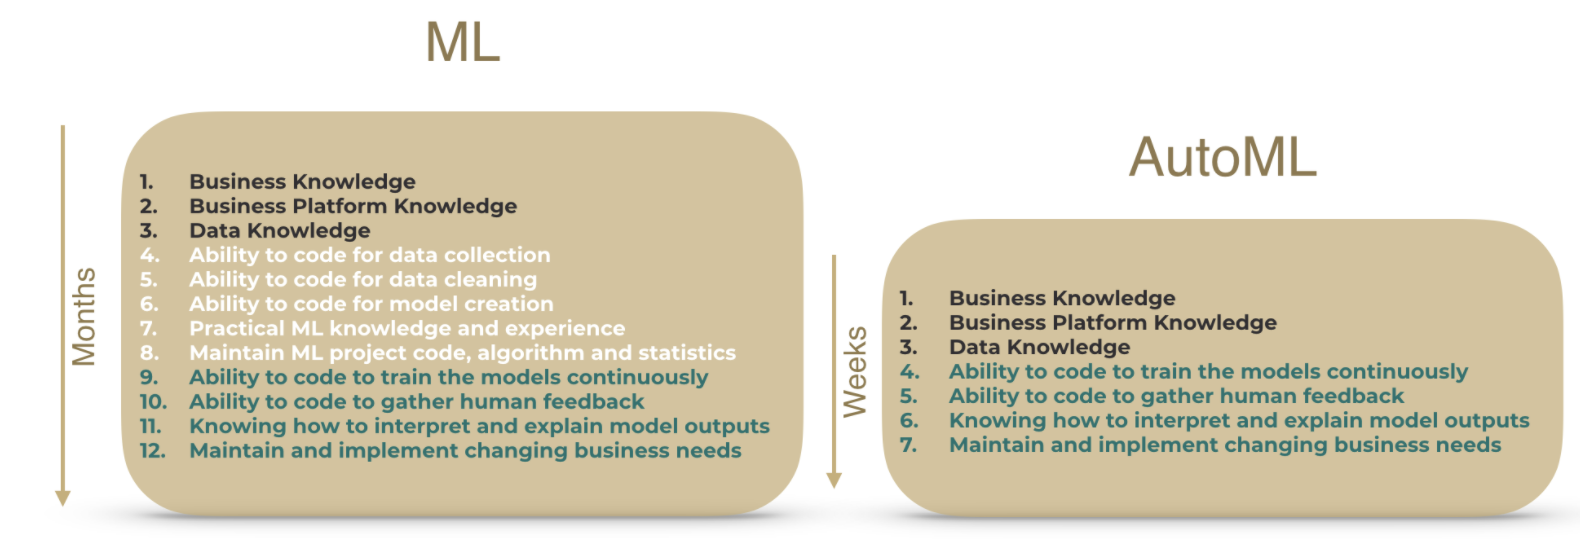

Existen diferentes framekorks para realizar AutoML:

- [Auto-SKLearn](https://www.automl.org/automl/auto-sklearn/)
- [MLBox](https://pypi.org/project/mlbox/)
- [TPOT](https://wiki.pathmind.com/automl-automated-machine-learning-ai)
- [H2O](https://www.h2o.ai/products/h2o-automl/) --> Incluye modelos de Deep Learning
- [AutoKeras](https://autokeras.com/) --> Incluye modelos de Deep Learning
- [MLJAR](https://mljar.com/) --> Incluye modelos de Deep Learning

Vamos a probar tanto AutoKeras como MLJAR.

**AutoKeras** nos va a proporcionar arquitecturas de Deep Learning empleando capas como las que hemos estado viendo hasta ahora. Permite resolver problemas de clasificación y regresión de datos estructurados, imágenes, textos y series temporales.

**MLJAR** realiza un gran trabajo para explicar los resultados obtenidos.

**NOTA**: Para instalar correctamente las librerías debemos de reiniciar el entorno de ejecución y, a posteriori, ejecutar la celda correspondiente al cargado de los datos.

In [ ]:
!pip install autokeras
!pip install mljar-supervised

     |████████████████████████████████| 166 kB 9.0 MB/s 
     |████████████████████████████████| 454.3 MB 14 kB/s 
     |████████████████████████████████| 97 kB 3.1 MB/s 
     |████████████████████████████████| 4.0 MB 26.5 MB/s 
     |████████████████████████████████| 462 kB 25.2 MB/s 
     |████████████████████████████████| 1.2 MB 37.6 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.40.0
    Uninstalling grpcio-1.40.0:
      Successfully uninstalled grpcio-1.40.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.0
    Uninstalling tensorflow-2.6.0:
      Successfully uninstalled tensorflow-2.6.0


     |████████████████████████████████| 110 kB 8.8 MB/s 
     |████████████████████████████████| 3.4 MB 39.9 MB/s 
     |████████████████████████████████| 11.3 MB 37.4 MB/s 
     |████████████████████████████████| 28.5 MB 38 kB/s 
     |████████████████████████████████| 22.3 MB 41 kB/s 
     |████████████████████████████████| 166.7 MB 16 kB/s 
     |████████████████████████████████| 2.0 MB 33.0 MB/s 
     |████████████████████████████████| 67.4 MB 30 kB/s 
     |████████████████████████████████| 61 kB 479 kB/s 
     |████████████████████████████████| 319 kB 37.8 MB/s 
     |████████████████████████████████| 366 kB 37.0 MB/s 
     |████████████████████████████████| 80 kB 7.3 MB/s 
     |████████████████████████████████| 302 kB 55.2 MB/s 
     |████████████████████████████████| 25.3 MB 72 kB/s 
     |████████████████████████████████| 208 kB 49.5 MB/s 
     |████████████████████████████████| 80 kB 8.2 MB/s 
     |████████████████████████████████| 75 kB 3.7 MB/s 
     |████████████████████

**1. AutoKeras**

Vamos a resolver de nuevo tanto el problema de regresión como de clasificación y exploraremos la arquitectura generada automáticamente.

En primer lugar vamos a preparar de nuevo los datos. Vamos a manterner el conjunto de datos de entrnamiento+validación ya que lo emplearemos cuando probemos MLJAR (internamente hace las particiones o emplea entropía cruzada según se especifique).

In [ ]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Cargado de datos y generación subsets entrenamiento, validación, test
(X_train_val, y_train_val), (X_test, y_test) = keras.datasets.boston_housing.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)

# Normalización
sc = StandardScaler()
sc.fit(X_train)
X_train_norm = sc.transform(X_train)
X_val_norm = sc.transform(X_val)
X_test_norm = sc.transform(X_test)

# Dataset clasificación
indices_bajo_train = np.where(y_train < 18.7)[0]
indices_medio_train = np.where((y_train >= 18.7) & (y_train < 23.6))[0]
indices_alto_train = np.where(y_train >= 23.6)[0]

y_train_labels = np.zeros(shape=(y_train.shape[0], 1))
y_train_labels[indices_bajo_train, 0] = 0
y_train_labels[indices_medio_train, 0] = 1
y_train_labels[indices_alto_train, 0] = 2

indices_bajo_val = np.where(y_val < 18.7)[0]
indices_medio_val = np.where((y_val >= 18.7) & (y_val < 23.6))[0]
indices_alto_val = np.where(y_val >= 23.6)[0]

y_val_labels = np.zeros(shape=(y_val.shape[0], 1))
y_val_labels[indices_bajo_val, 0] = 0
y_val_labels[indices_medio_val, 0] = 1
y_val_labels[indices_alto_val, 0] = 2

indices_bajo_test = np.where(y_test < 18.7)[0]
indices_medio_test = np.where((y_test >= 18.7) & (y_test < 23.6))[0]
indices_alto_test = np.where(y_test >= 23.6)[0]

y_test_labels = np.zeros(shape=(y_test.shape[0], 1))
y_test_labels[indices_bajo_test, 0] = 0
y_test_labels[indices_medio_test, 0] = 1
y_test_labels[indices_alto_test, 0] = 2

indices_bajo_train_val = np.where(y_train_val < 18.7)[0]
indices_medio_train_val = np.where((y_train_val >= 18.7) & (y_train_val < 23.6))[0]
indices_alto_train_val = np.where(y_train_val >= 23.6)[0]

y_train_val_labels = np.zeros(shape=(y_train_val.shape[0], 1))
y_train_val_labels[indices_bajo_train_val, 0] = 0
y_train_val_labels[indices_medio_train_val, 0] = 1
y_train_val_labels[indices_alto_train_val, 0] = 2

y_train_coded = LabelEncoder().fit_transform(y_train_labels)
y_val_coded = LabelEncoder().fit_transform(y_val_labels)
y_test_coded = LabelEncoder().fit_transform(y_test_labels)
y_train_val_coded = LabelEncoder().fit_transform(y_train_val_labels)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [ ]:
# Importamos librería para resolver problemas de regresión
from autokeras import StructuredDataRegressor

In [ ]:
search = StructuredDataRegressor(max_trials=15, loss='mse')
# perform the search
search.fit(x=X_train, y=y_train, verbose=0,
           validation_data=(X_val, y_val))

INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ./structured_data_regressor/best_model/assets


In [ ]:
model = search.export_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 13)                0         
_________________________________________________________________
normalization (Normalization (None, 13)                27        
_________________________________________________________________
dense (Dense)                (None, 1024)              14336     
_________________________________________________________________
re_lu (ReLU)                 (None, 1024)              0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 1)                 1025      
Total params: 15,388
Trainable params: 15,361
Non-trainable params: 27
________________________________________________________

In [ ]:
import numpy as np

_, mse = search.evaluate(X_test, y_test, verbose=0)
print('Error cuadrático medio en test: ', mse)
print('Raiz del error cuadrático medio en test: ', np.sqrt(mse))

Error cuadrático medio en test:  13.339950561523438
Raiz del error cuadrático medio en test:  3.652389705593235


In [ ]:
from autokeras import StructuredDataClassifier
from sklearn.preprocessing import LabelEncoder

y_train_coded = LabelEncoder().fit_transform(y_train_labels)
y_val_coded = LabelEncoder().fit_transform(y_val_labels)
search_class = StructuredDataClassifier(max_trials=10)
# perform the search
search_class.fit(x=X_train, y=y_train_coded, verbose=0,
                 validation_data=(X_val, y_val_coded))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Assets written to: ./structured_data_classifier/best_model/assets


In [ ]:
model_class = search_class.export_model()

model_class.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 13)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 13)                0         
_________________________________________________________________
normalization (Normalization (None, 13)                27        
_________________________________________________________________
dense (Dense)                (None, 32)                448       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 64)                0     

In [ ]:
_, acc = search_class.evaluate(X_test, y_test_coded, verbose=0)
print('Precisión test: ', acc)

Precisión test:  0.7745097875595093


**2. MLJAR**

Vamos a emplear la API correspondiente a [apredinzaje supervisado](https://supervised.mljar.com/)

In [ ]:
from supervised.automl import AutoML
from sklearn.preprocessing import LabelEncoder

automl = AutoML()
automl.fit(X_train_val, y_train_val_coded)

predictions = automl.predict(X_test)

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


AutoML directory: AutoML_1
The task is multiclass_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 1.098643 trained in 0.46 seconds
2_DecisionTree logloss 0.791202 trained in 17.88 seconds
3_Linear logloss 0.601416 trained in 9.63 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.492449 trained in 11.5 seconds
5_Default_NeuralNetwork logloss 0.559667 trained in 1.24 seconds
6_Default_RandomForest logloss 0.581106 trained in 14.74 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.474625 trained in 0.35 seconds
AutoML fit time: 71.74 seconds
AutoML best model: Ensemble
